In [1]:
library(DESeq2)
library(tximport)
library(dplyr)
library(ggplot2)
library(ggrepel)
library(tidyverse)
library(pheatmap)
library(ggthemes)
library(clusterProfiler)
library(enrichplot)
library("org.Hs.eg.db")
library(ggvenn)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loading required package: SummarizedExperiment

Loading required package: M

In [2]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS/LAPACK: /home/trc891/.conda/envs/cfn_final/lib/libopenblasp-r0.3.29.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggvenn_0.1.10               org.Hs.eg.db_3.16.0        
 [3] AnnotationDbi_1.60.0        enrichplot_1.18.0          
 [5] clusterProfiler_4.6.0       ggthemes_5.1.0             
 [7] pheatmap_1.0.12             lubridate_1.9.3            
 [9] forcats

In [3]:
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)

In [4]:
plotPCA_manual = function(object, 
                          intgroup="condition", #essentially ignored if merge_metadata = TRUE
                          ntop=500, 
                          pcs = 2,
                          merge_metadata = FALSE,
                          return_loadings = FALSE,
                          mart_name = "mmusculus",
                          custom_annotation = NULL)
{
#   require(tidyverse)
  
  # calculate the variance for each gene
  rv <- rowVars(assay(object), useNames=TRUE)
  
  # select the ntop genes by variance
  select <- order(rv, decreasing=TRUE)[seq_len(min(ntop, length(rv)))]
  
  # perform a PCA on the data in assay(x) for the selected genes
  pca <- prcomp(t(assay(object)[select,]))
  
  # the contribution to the total variance for each component
  percentVar <- pca$sdev^2 / sum( pca$sdev^2 )
  
  if (!all(intgroup %in% names(colData(object)))) {
    stop("the argument 'intgroup' should specify columns of colData(dds)")
  }
  
  intgroup.df <- as.data.frame(colData(object)[, intgroup, drop=FALSE])
  
  # add the intgroup factors together to create a new grouping factor
  group <- if (length(intgroup) > 1) {
    factor(apply( intgroup.df, 1, paste, collapse=":"))
  } else {
    colData(object)[[intgroup]]
  }
  
  # assemble the data for the plot
  d <- data.frame(group=group, intgroup.df, name=colnames(object))
  tmp = pca$x[, 1:pcs]
  colnames(tmp) = paste0("PC", 1:pcs)
  d = cbind(tmp, d)
  attr(d, "percentVar") <- percentVar[1:pcs]
  
  if(merge_metadata == TRUE)
  {
    md = colData(object) %>% 
      as.data.frame() %>% 
      rownames_to_column("sample")
    d = d %>% 
      dplyr::select(-group) %>% 
      dplyr::rename(sample = name) %>% 
      left_join(., md) %>% 
      column_to_rownames("sample")
  }
      
  
  plt = ggplot(data=d, aes_string(x="PC1", y="PC2", color=group)) + geom_point(size=3) + 
    xlab(paste0("PC1: ",round(percentVar[1] * 100),"% variance")) +
    ylab(paste0("PC2: ",round(percentVar[2] * 100),"% variance")) +
    coord_fixed()
  
  #if requested, return loadings in human-readable format
  if(return_loadings == TRUE)
  {
    if(is.null(custom_annotation))
    {
      require(biomaRt)
      mart = useMart("ensembl", paste0(mart_name, "_gene_ensembl"))
      conv = getBM(attributes = c("ensembl_gene_id", "external_gene_name"),
                   mart = mart)
    } else
    {
      conv = custom_annotation
    }
    
    loadings = pca$rotation %>% 
      as.data.frame() %>% 
      rownames_to_column("ensembl_gene_id") %>% 
      left_join(., conv) %>% 
      dplyr::relocate(ensembl_gene_id, external_gene_name) %>% 
      arrange(desc(PC1))
  } else
  {
    loadings = NULL
  }
  
  #output percent variance for each PC as a tidy data frame
  percent_var = data.frame(component = 1:pcs, percent_var = round(percentVar[1:pcs] * 100))
  
  return(list(pca = pca, data = d, plot = plt, loadings = loadings, percent_var = percent_var))
}

In [5]:
fig1.data.dir = "/home/trc891/projects/cyb/2022-CFnose/data/03CF_3173"
fig1.out.dir = "/home/trc891/projects/cyb/2022-CFnose/data/10paper_figures/fig1"
fig2.out.dir = "/home/trc891/projects/cyb/2022-CFnose/data/10paper_figures/fig2"

In [6]:
# load demographic info
fig1.demo <- read.csv(file.path(fig1.data.dir, "3173_samples_20240913.csv"))
fig1.demo <- fig1.demo %>% filter(!fig1.demo$Sample %in% c("NC002RLT"))

fig1.demo$Class[fig1.demo$Class == 'NC'] <- 'HV'

fig1.demo[fig1.demo$Class == "HV", ]$HEMTStatus <- "HV"

In [7]:
summary(type.convert(fig1.demo, as.is=FALSE))

     Sample           Sample_old              SampleID   Class   
 01CF   : 1   01CF         : 1   01CF_S9          : 1   CF  :43  
 25CF   : 1   20230119uRNA1: 1   20230119uRNA1_S52: 1   CTRL: 2  
 CF02   : 1   25CF         : 1   25CF_S33         : 1   HV  : 7  
 CF03   : 1   CF02         : 1   CF02_S10         : 1            
 CF04   : 1   CF03         : 1   CF03_S11         : 1            
 CF05   : 1   CF04         : 1   CF04_S12         : 1            
 (Other):46   (Other)      :46   (Other)          :46            
      RIN        CFTRMod       ModType       ppFEV1            Age       
 Min.   :2.600   N   :11   Kalydeco: 2   Min.   : 30.00   Min.   :20.00  
 1st Qu.:7.100   Y   :32   Kalydeko: 1   1st Qu.: 76.75   1st Qu.:25.00  
 Median :7.700   NA's: 9   Orkambi : 1   Median : 90.50   Median :28.50  
 Mean   :7.137             Symdeko : 3   Mean   : 87.16   Mean   :32.46  
 3rd Qu.:8.100             Trikafta:25   3rd Qu.: 97.50   3rd Qu.:37.00  
 Max.   :8.900             N

In [8]:
cf.all.demo <- type.convert(fig1.demo[fig1.demo$Class == 'CF', ], as.is=FALSE)
summary(cf.all.demo)

     Sample     Sample_old     SampleID  Class        RIN        CFTRMod
 01CF   : 1   01CF   : 1   01CF_S9 : 1   CF:43   Min.   :2.600   N:11   
 25CF   : 1   25CF   : 1   25CF_S33: 1           1st Qu.:6.325   Y:32   
 CF02   : 1   CF02   : 1   CF02_S10: 1           Median :7.650          
 CF03   : 1   CF03   : 1   CF03_S11: 1           Mean   :6.967          
 CF04   : 1   CF04   : 1   CF04_S12: 1           3rd Qu.:8.000          
 CF05   : 1   CF05   : 1   CF05_S13: 1           Max.   :8.900          
 (Other):37   (Other):37   (Other) :37           NA's   :1              
     ModType       ppFEV1            Age        Sex     PsA     F508delStatus
 Kalydeco: 2   Min.   : 30.00   Min.   :20.00   F:22   N  :27   Het    :15   
 Kalydeko: 1   1st Qu.: 76.75   1st Qu.:24.00   M:21   UNK: 2   Hom    :20   
 Orkambi : 1   Median : 90.50   Median :28.00          Y  :14   Neither: 4   
 Symdeko : 3   Mean   : 87.16   Mean   :31.49                   UNK    : 4   
 Trikafta:25   3rd Qu.: 97

In [9]:
hv.all.demo <- type.convert(fig1.demo[fig1.demo$Class == 'HV', ], as.is=FALSE)
summary(hv.all.demo)

   Sample  Sample_old     SampleID Class       RIN        CFTRMod       
 NC001:1   NC001:1    NC001_S1:1   HV:7   Min.   :7.200   Mode:logical  
 NC002:1   NC002:1    NC002_S2:1          1st Qu.:7.825   NA's:7        
 NC003:1   NC003:1    NC003_S4:1          Median :8.100                 
 NC004:1   NC004:1    NC004_S5:1          Mean   :8.067                 
 NC005:1   NC005:1    NC005_S6:1          3rd Qu.:8.525                 
 NC006:1   NC006:1    NC006_S7:1          Max.   :8.600                 
 NC007:1   NC007:1    NC007_S8:1          NA's   :1                     
 ModType         ppFEV1             Age        Sex     PsA         
 Mode:logical   Mode:logical   Min.   :25.00   F:4   Mode:logical  
 NA's:7         NA's:7         1st Qu.:28.50   M:3   NA's:7        
                               Median :32.00                       
                               Mean   :38.43                       
                               3rd Qu.:47.50                       
        

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_bin()`).”


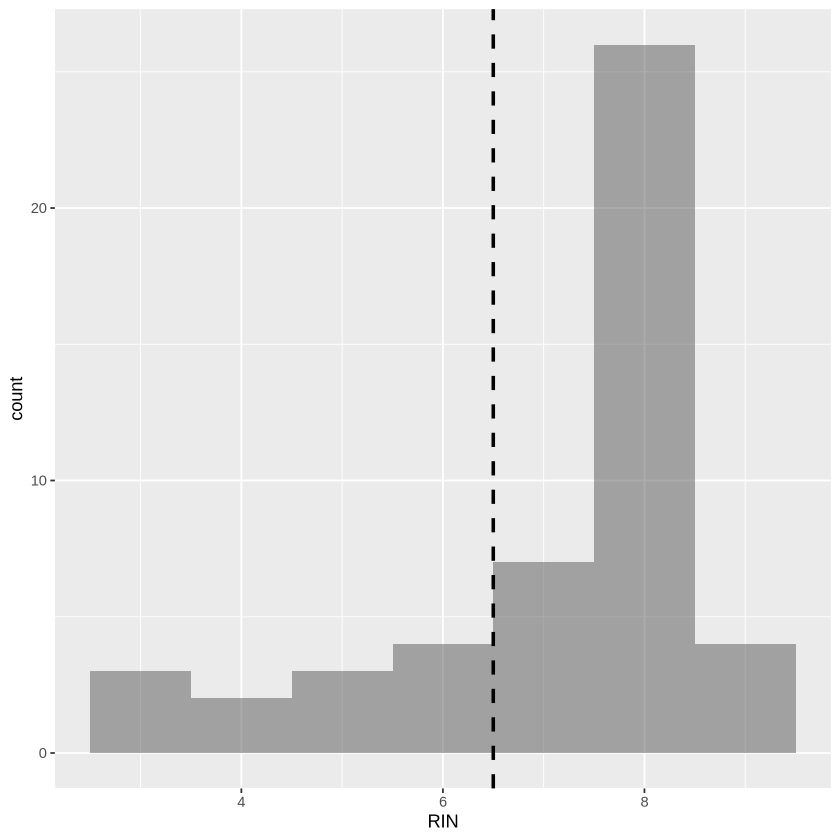

In [10]:
ggplot(fig1.demo, aes(x=RIN)) +
    geom_histogram(binwidth=1, alpha=0.5) +
    geom_vline(aes(xintercept=6.5), color="black", linetype="dashed", size=1)

In [10]:
# uRNA, Undetermined - not samples
# NC002RLT - scRLT sample, does not use the same sample processing
# CF31, CF33 - possibly mislabeled, have sex mismatches per XIST expression
# CF27 - Poor sequence quality
# 25CF - Low number of reads, low amount aligned, high % dups

filter.samples <- c('uRNA', 'NC002RLT', 'CF31', 'CF33', 'CF27', '25CF', 'Undetermined')

fig1.demo.sel <- fig1.demo %>% filter(!fig1.demo$Sample %in% filter.samples)
fig1.demo.sel <- fig1.demo.sel %>% filter(fig1.demo.sel$RIN > 6.5)
fig1.demo.sel

Sample,Sample_old,SampleID,Class,RIN,CFTRMod,ModType,ppFEV1,Age,Sex,PsA,F508delStatus,HEMTStatus
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
01CF,01CF,01CF_S9,CF,8.1,Y,Symdeko,75,29,F,Y,Hom,N
CF02,CF02,CF02_S10,CF,8.0,Y,Trikafta,81,50,M,Y,Hom,Y
CF03,CF03,CF03_S11,CF,8.4,Y,Trikafta,80,25,F,N,Hom,Y
CF04,CF04,CF04_S12,CF,8.2,Y,Trikafta,30,28,M,N,Hom,Y
CF08,CF08,CF08_S16,CF,8.3,Y,Trikafta,95,33,F,N,Hom,Y
CF10,CF10,CF10_S18,CF,8.2,N,NA,79,64,M,N,Het,N
CF11,CF11,CF11_S19,CF,8.9,Y,Trikafta,104,36,M,Y,Hom,Y
CF14,CF14,CF14_S22,CF,7.1,Y,Symdeko,NA,24,M,Y,Hom,N
CF17,CF17,CF17_S25,CF,8.1,Y,Kalydeco,NA,26,F,Y,Neither,N


## Demographics

In [11]:
cf.demo <- type.convert(fig1.demo.sel[fig1.demo.sel$Class == 'CF', ], as.is=FALSE)
summary(cf.demo)

     Sample     Sample_old     SampleID  Class        RIN        CFTRMod
 01CF   : 1   01CF   : 1   01CF_S9 : 1   CF:27   Min.   :7.100   N: 7   
 CF02   : 1   CF02   : 1   CF02_S10: 1           1st Qu.:7.700   Y:20   
 CF03   : 1   CF03   : 1   CF03_S11: 1           Median :7.900          
 CF04   : 1   CF04   : 1   CF04_S12: 1           Mean   :7.922          
 CF08   : 1   CF08   : 1   CF08_S16: 1           3rd Qu.:8.150          
 CF10   : 1   CF10   : 1   CF10_S18: 1           Max.   :8.900          
 (Other):21   (Other):21   (Other) :21                                  
     ModType       ppFEV1            Age        Sex    PsA    F508delStatus
 Kalydeco: 1   Min.   : 30.00   Min.   :21.00   F:12   N:17   Het    : 9   
 Kalydeko: 1   1st Qu.: 79.75   1st Qu.:24.00   M:15   Y:10   Hom    :12   
 Symdeko : 2   Median : 94.50   Median :27.00                 Neither: 2   
 Trikafta:16   Mean   : 92.83   Mean   :30.67                 UNK    : 4   
 NA's    : 7   3rd Qu.:102.00   3rd 

In [12]:
hv.demo <- type.convert(fig1.demo.sel[fig1.demo.sel$Class == 'HV', ], as.is=FALSE)
summary(hv.demo)

   Sample  Sample_old     SampleID Class       RIN        CFTRMod       
 NC001:1   NC001:1    NC001_S1:1   HV:6   Min.   :7.200   Mode:logical  
 NC002:1   NC002:1    NC002_S2:1          1st Qu.:7.825   NA's:6        
 NC003:1   NC003:1    NC003_S4:1          Median :8.100                 
 NC004:1   NC004:1    NC004_S5:1          Mean   :8.067                 
 NC005:1   NC005:1    NC005_S6:1          3rd Qu.:8.525                 
 NC006:1   NC006:1    NC006_S7:1          Max.   :8.600                 
 ModType         ppFEV1             Age        Sex     PsA         
 Mode:logical   Mode:logical   Min.   :25.00   F:3   Mode:logical  
 NA's:6         NA's:6         1st Qu.:27.75   M:3   NA's:6        
                               Median :33.50                       
                               Mean   :39.50                       
                               3rd Qu.:52.75                       
                               Max.   :60.00                       
 F508delStatu

## Load selected Salmon output

In [13]:
# generate a list - salmon count filename for each sample
fig1.files <- file.path(fig1.data.dir, "nf_rnaseq_grch38_v113_out", "star_salmon", fig1.demo.sel$SampleID, "quant.sf")
names(fig1.files) <- fig1.demo.sel$SampleID
all(file.exists(fig1.files))

[1] TRUE

In [14]:
# Can use this for both figure 1 and figure 2
tx2gene <- read.table(file.path(fig1.data.dir, "nf_rnaseq_grch38_v113_out", "star_salmon", "salmon_tx2gene.tsv"))
colnames(tx2gene) <- c("TXNAME", "GENEID", "GENENAME")
head(tx2gene)

,TXNAME,GENEID,GENENAME
,<chr>,<chr>,<chr>
1,ENST00000511072,ENSG00000142611,PRDM16
2,ENST00000607632,ENSG00000142611,PRDM16
3,ENST00000378391,ENSG00000142611,PRDM16
4,ENST00000514189,ENSG00000142611,PRDM16
5,ENST00000270722,ENSG00000142611,PRDM16
6,ENST00000512462,ENSG00000142611,PRDM16


In [15]:
fig1.txi <- tximport(fig1.files, type="salmon", tx2gene=tx2gene)
names(fig1.txi)

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 
31 
32 
33 


summarizing abundance

summarizing counts

summarizing length



[1] "abundance"           "counts"              "length"             
[4] "countsFromAbundance"

In [16]:
# generate DESeqDataSet dds from txi and samples
fig1.sampleTable <- data.frame(condition=fig1.demo.sel$Class,
                               RIN=fig1.demo.sel$RIN,
                               age=fig1.demo.sel$Age,
                               sex=fig1.demo.sel$Sex
                              )

rownames(fig1.sampleTable) <- fig1.demo.sel$SampleID

fig1.dds <- DESeqDataSetFromTximport(fig1.txi, fig1.sampleTable, ~condition+sex)

fig1.dds

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
using counts and average transcript lengths from tximport



class: DESeqDataSet 
dim: 78932 33 
metadata(1): version
assays(2): counts avgTxLength
rownames(78932): ENSG00000000003 ENSG00000000005 ... ENSG00000310556
  ENSG00000310557
rowData names(0):
colnames(33): 01CF_S9 CF02_S10 ... NC005_S6 NC006_S7
colData names(4): condition RIN age sex

In [17]:
# Remove genes with less than 11 counts across all samples
fig1.keep <- rowSums(counts(fig1.dds)) >= 10

fig1.dds <- fig1.dds[fig1.keep, ]

In [18]:
fig1.dds

class: DESeqDataSet 
dim: 57392 33 
metadata(1): version
assays(2): counts avgTxLength
rownames(57392): ENSG00000000003 ENSG00000000005 ... ENSG00000310556
  ENSG00000310557
rowData names(0):
colnames(33): 01CF_S9 CF02_S10 ... NC005_S6 NC006_S7
colData names(4): condition RIN age sex

using 'avgTxLength' from assays(dds), correcting for library size



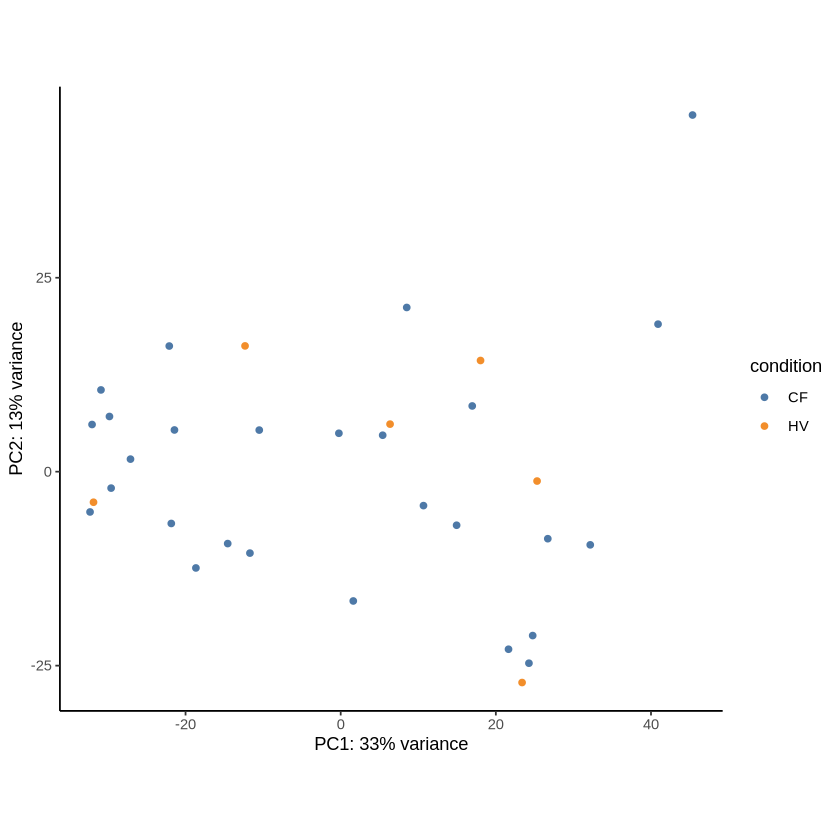

In [19]:
fig1.d <- plotPCA(vst(fig1.dds), intgroup = c("condition"), returnData=TRUE)
fig1.percentVar <- round(100 * attr(fig1.d, "percentVar"))

ggplot(fig1.d, aes(x=PC1, y=PC2, color=condition)) +
    geom_point() +
    #geom_label_repel(aes(label = fig1.demo.sel$Sample), show.legend=FALSE) +
    xlab(paste0("PC1: ", fig1.percentVar[1], "% variance")) +
    ylab(paste0("PC2: ", fig1.percentVar[2], "% variance")) +
    coord_fixed() +
    scale_color_tableau(palette = 'Tableau 10') +
    theme_classic()

ggsave(file.path(fig1.out.dir, "fig1a.png"), height=3, width=3, dpi=300, unit='in')
ggsave(file.path(fig1.out.dir, "fig1a.svg"), height=3, width=3, dpi=300, unit='in')

In [20]:
fig1.d.manual <- plotPCA_manual(
                                vst(fig1.dds),
                                intgroup=c("condition"),
                                ntop=500,
                                pcs=10
                                )
percentVar <- round(100 * attr(fig1.d.manual$data, "percentVar"))

using 'avgTxLength' from assays(dds), correcting for library size

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


In [21]:
loadings <- data.frame(fig1.d.manual$pca$rotation)
genes <- rownames(loadings)

In [22]:
for (i in 1:10) {
    print(sprintf("PC%d: %d %% variance", i, percentVar[i]))
    l <- loadings[, i]
    ord <- order (abs(l), decreasing=TRUE)
    g <- genes[ord][1:20]
    v <- paste(tx2gene[match(g, tx2gene$GENEID), ]$GENENAME, " (", round(l[ord][1:20], 4), ")")
    print(paste(v, collapse=", "))
    print("=========")
}

[1] "PC1: 33 % variance"
[1] "ERICH3  ( -0.1001 ), CIMIP1  ( -0.0996 ), FAM216B  ( -0.099 ), DNAAF1  ( -0.0955 ), TPPP3  ( -0.0952 ), DRC1  ( -0.0947 ), SNTN  ( -0.0945 ), CFAP43  ( -0.0931 ), RSPH1  ( -0.0927 ), RSPH4A  ( -0.091 ), DNALI1  ( -0.0907 ), DNAH12  ( -0.0897 ), LRRIQ1  ( -0.0885 ), SPAG6  ( -0.0848 ), ODAD4  ( -0.0838 ), DNAH3  ( -0.0837 ), CAPSL  ( -0.0806 ), DNAH6  ( -0.0804 ), ENSG00000258752  ( -0.0801 ), CFAP45  ( -0.0797 )"
[1] "========="
[1] "PC2: 13 % variance"
[1] "ENSG00000302987  ( 0.115 ), MGAT5B  ( 0.1045 ), MIR124-1HG  ( 0.1042 ), G0S2  ( 0.1041 ), LINC01978  ( 0.1 ), FCGR3B  ( 0.0998 ), ENSG00000301659  ( 0.0998 ), TREM1  ( 0.0994 ), HCFC1-AS1  ( 0.098 ), CXCL8  ( 0.0968 ), IL1B  ( 0.0947 ), CSF3R  ( 0.093 ), AQP9  ( 0.0929 ), ILDR2  ( 0.0899 ), OSM  ( 0.0897 ), NPFFR1  ( 0.0885 ), MYT1L  ( 0.0879 ), DIP2C-AS1  ( 0.0879 ), THUMPD1P1  ( 0.0878 ), IPO7P1  ( 0.0873 )"
[1] "========="
[1] "PC3: 7 % variance"
[1] "RMRP  ( -0.1263 ), ENSG00000302987  ( 0.1225 ), 

In [23]:
fig1.dds <- DESeq(fig1.dds)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1678 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [24]:
cf.vs.ctrl <- as.data.frame(results(fig1.dds, contrast=c("condition", "CF", "HV")))
cf.vs.ctrl <- cf.vs.ctrl[!is.na(cf.vs.ctrl$padj), ]
cf.vs.ctrl$sign <- ""
cf.vs.ctrl$sign[(cf.vs.ctrl$log2FoldChange < 0) & (cf.vs.ctrl$padj < 0.05)] <- "Down"
cf.vs.ctrl$sign[(cf.vs.ctrl$log2FoldChange > 0) & (cf.vs.ctrl$padj < 0.05)] <- "Up"
cf.vs.ctrl <- cf.vs.ctrl[order(cf.vs.ctrl$sign), ]
cf.vs.ctrl$GENENAME <- tx2gene[match(rownames(cf.vs.ctrl), tx2gene$GENEID), ]$GENENAME

In [25]:
cf.vs.ctrl[cf.vs.ctrl$padj < 0.05, ]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,sign,GENENAME
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSG00000008130,961.683772,-0.9158900,0.2397333,-3.820454,1.332065e-04,4.931900e-02,Down,NADK
ENSG00000050555,12.897161,-3.3204753,0.6985318,-4.753506,1.999192e-06,4.638524e-03,Down,LAMC3
ENSG00000090402,4.133131,-4.8896740,1.2481246,-3.917617,8.942864e-05,3.890481e-02,Down,SI
ENSG00000095713,8.697585,-2.4231864,0.6110346,-3.965711,7.317754e-05,3.682859e-02,Down,CRTAC1
ENSG00000099308,305.310426,-1.4154009,0.3549835,-3.987230,6.684913e-05,3.613618e-02,Down,MAST3
ENSG00000110203,11.999806,-6.5177302,1.3263514,-4.914030,8.922326e-07,2.445158e-03,Down,FOLR3
ENSG00000116337,469.917940,-1.9189873,0.4491582,-4.272408,1.933729e-05,1.922845e-02,Down,AMPD2
ENSG00000128272,2080.271606,-0.4956659,0.1231536,-4.024778,5.702900e-05,3.253738e-02,Down,ATF4
ENSG00000129214,21.075062,-4.0965856,0.8344294,-4.909446,9.133423e-07,2.445158e-03,Down,SHBG


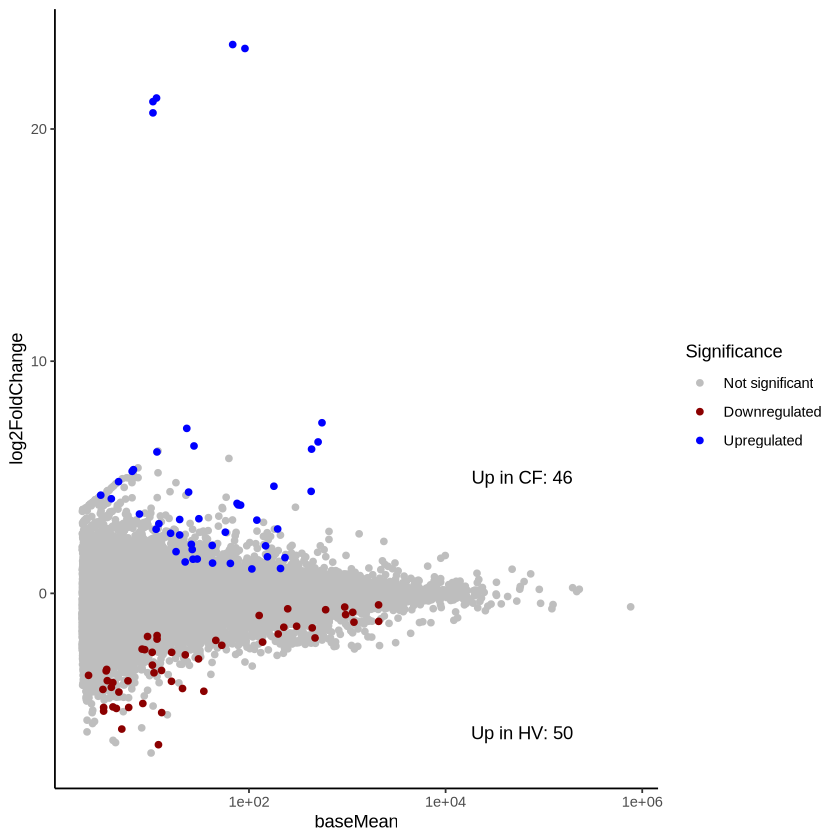

In [26]:
ggplot(cf.vs.ctrl, aes(x=baseMean, y=log2FoldChange)) +
    geom_point(aes(fill=sign, color=sign), stroke=0.5) +
    # ylim(-10, 10)
    #geom_label_repel(
    #    aes(label = GENENAME, fontface = "italic"), 
    #    data = cf.vs.ctrl[cf.vs.ctrl$padj < 0.05, ],
    #    box.padding = 0.5,
    #    seed = 5000,
    #) +
    scale_x_log10() +
    scale_color_manual(values = c("gray", "darkred", "blue"), name = "Significance", labels = c("Not significant", "Downregulated", "Upregulated")) +
    scale_fill_manual(values = c("gray", "darkred", "blue"), name = "Significance", labels = c("Not significant", "Downregulated", "Upregulated")) + 
    annotate("text", x = 6e+04, y = 5, label = sprintf("Up in CF: %d", sum(cf.vs.ctrl$sign == "Up"))) +
    annotate("text", x = 6e+04, y = -6, label = sprintf("Up in HV: %d", sum(cf.vs.ctrl$sign == "Down"))) +
    theme_classic()

ggsave(file.path(fig1.out.dir, "fig1b.png"), height=3, width=4.5, dpi=300, unit='in')
ggsave(file.path(fig1.out.dir, "fig1b.svg"), height=3, width=4.5, dpi=300, unit='in')

## HEMT vs No HEMT, also No HEMT vs HV

In [27]:
# generate DESeqDataSet dds from txi and samples
fig2.hemt.sampleTable <- data.frame(condition=fig1.demo.sel$Class,
                                    RIN=fig1.demo.sel$RIN,
                                    age=fig1.demo.sel$Age,
                                    sex=fig1.demo.sel$Sex,
                                    hemt=factor(fig1.demo.sel$HEMTStatus)
                                   )

rownames(fig2.hemt.sampleTable) <- fig1.demo.sel$SampleID

fig2.hemt.dds <- DESeqDataSetFromTximport(fig1.txi, fig2.hemt.sampleTable, ~hemt+sex)

fig2.hemt.dds

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
using counts and average transcript lengths from tximport



class: DESeqDataSet 
dim: 78932 33 
metadata(1): version
assays(2): counts avgTxLength
rownames(78932): ENSG00000000003 ENSG00000000005 ... ENSG00000310556
  ENSG00000310557
rowData names(0):
colnames(33): 01CF_S9 CF02_S10 ... NC005_S6 NC006_S7
colData names(5): condition RIN age sex hemt

In [28]:
# Remove genes with less than 11 counts across all samples
fig2.hemt.keep <- rowSums(counts(fig2.hemt.dds)) >= 10

fig2.hemt.dds <- fig2.hemt.dds[fig2.hemt.keep, ]

fig2.hemt.dds

class: DESeqDataSet 
dim: 57392 33 
metadata(1): version
assays(2): counts avgTxLength
rownames(57392): ENSG00000000003 ENSG00000000005 ... ENSG00000310556
  ENSG00000310557
rowData names(0):
colnames(33): 01CF_S9 CF02_S10 ... NC005_S6 NC006_S7
colData names(5): condition RIN age sex hemt

In [29]:
fig2.hemt.dds <- DESeq(fig2.hemt.dds)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1107 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [30]:
hemt.vs.nohemt <- as.data.frame(results(fig2.hemt.dds, contrast=c("hemt", "Y", "N")))
hemt.vs.nohemt <- hemt.vs.nohemt[!is.na(hemt.vs.nohemt$padj), ]
hemt.vs.nohemt$sign <- ""
hemt.vs.nohemt$sign[(hemt.vs.nohemt$log2FoldChange < 0) & (hemt.vs.nohemt$padj < 0.05)] <- "Down"
hemt.vs.nohemt$sign[(hemt.vs.nohemt$log2FoldChange > 0) & (hemt.vs.nohemt$padj < 0.05)] <- "Up"
hemt.vs.nohemt <- hemt.vs.nohemt[order(hemt.vs.nohemt$sign), ]
hemt.vs.nohemt$GENENAME <- tx2gene[match(rownames(hemt.vs.nohemt), tx2gene$GENEID), ]$GENENAME

In [31]:
hemt.vs.nohemt[hemt.vs.nohemt$padj < 0.05, ]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,sign,GENENAME
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSG00000004809,46.955394,-2.9692300,0.6897036,-4.305081,1.669247e-05,1.436943e-02,Down,SLC22A16
ENSG00000062822,442.758911,-2.2896832,0.5841571,-3.919636,8.868283e-05,4.321196e-02,Down,POLD1
ENSG00000099840,785.358883,-4.6528042,0.8272259,-5.624587,1.859521e-08,9.604427e-05,Down,IZUMO4
ENSG00000100027,21.199540,-1.8929220,0.4812807,-3.933093,8.385970e-05,4.191266e-02,Down,YPEL1
ENSG00000100346,220.512172,-4.1334161,0.6597519,-6.265107,3.725697e-10,4.810806e-06,Down,CACNA1I
ENSG00000105559,556.315949,-1.2649848,0.3262657,-3.877162,1.056821e-04,4.788140e-02,Down,PLEKHA4
ENSG00000105695,13.329128,-2.8622911,0.6422551,-4.456626,8.325950e-06,1.075088e-02,Down,MAG
ENSG00000106336,70.985098,-2.9468603,0.5969940,-4.936164,7.967429e-07,2.939412e-03,Down,FBXO24
ENSG00000113805,651.586827,-2.5674839,0.6589632,-3.896248,9.769454e-05,4.505289e-02,Down,CNTN3


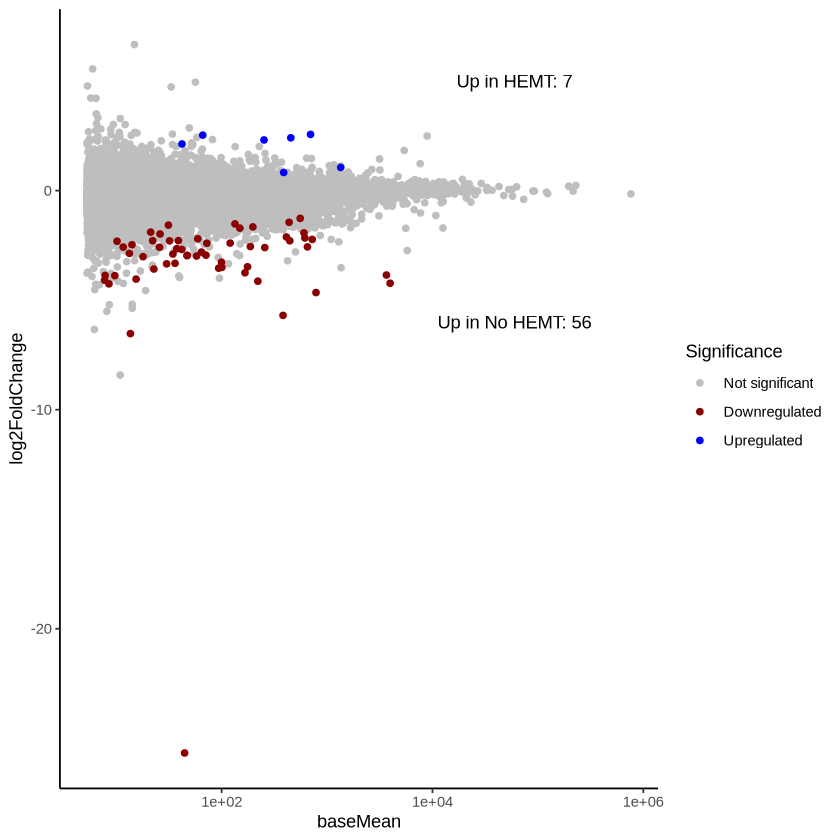

In [32]:
ggplot(hemt.vs.nohemt, aes(x=baseMean, y=log2FoldChange)) +
    geom_point(aes(fill=sign, color=sign), stroke=0.5) +
    # ylim(-10, 10)
    #geom_label_repel(
    #    aes(label = GENENAME, fontface = "italic"), 
    #    data = hemt.vs.nohemt[hemt.vs.nohemt$padj < 0.05, ],
    #    box.padding = 0.5,
    #    seed = 5000,
    #) +
    scale_x_log10() +
    scale_color_manual(values = c("gray", "darkred", "blue"), name = "Significance", labels = c("Not significant", "Downregulated", "Upregulated")) +
    scale_fill_manual(values = c("gray", "darkred", "blue"), name = "Significance", labels = c("Not significant", "Downregulated", "Upregulated")) + 
    annotate("text", x = 6e+04, y = 5, label = sprintf("Up in HEMT: %d", sum(hemt.vs.nohemt$sign == "Up"))) +
    annotate("text", x = 6e+04, y = -6, label = sprintf("Up in No HEMT: %d", sum(hemt.vs.nohemt$sign == "Down"))) +
    theme_classic()

ggsave(file.path(fig2.out.dir, "fig2a.png"), height=3, width=5, dpi=300, unit='in')
ggsave(file.path(fig2.out.dir, "fig2a.svg"), height=3, width=5, dpi=300, unit='in')

In [33]:
nohemt.vs.hv <- as.data.frame(results(fig2.hemt.dds, contrast=c("hemt", "N", "HV")))
nohemt.vs.hv <- nohemt.vs.hv[!is.na(nohemt.vs.hv$padj), ]
nohemt.vs.hv$sign <- ""
nohemt.vs.hv$sign[(nohemt.vs.hv$log2FoldChange < 0) & (nohemt.vs.hv$padj < 0.05)] <- "Down"
nohemt.vs.hv$sign[(nohemt.vs.hv$log2FoldChange > 0) & (nohemt.vs.hv$padj < 0.05)] <- "Up"
nohemt.vs.hv <- nohemt.vs.hv[order(nohemt.vs.hv$sign), ]
nohemt.vs.hv$GENENAME <- tx2gene[match(rownames(nohemt.vs.hv), tx2gene$GENEID), ]$GENENAME

In [34]:
nohemt.vs.hv[nohemt.vs.hv$padj < 0.05, ]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,sign,GENENAME
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSG00000050555,12.897161,-3.8987859,0.8056881,-4.839076,1.304442e-06,3.580100e-03,Down,LAMC3
ENSG00000079277,369.665410,-0.7470661,0.1730938,-4.315961,1.589097e-05,2.085863e-02,Down,MKNK1
ENSG00000110203,11.999806,-6.3242989,1.5615562,-4.049997,5.121818e-05,4.483888e-02,Down,FOLR3
ENSG00000128272,2080.271606,-0.5630259,0.1407049,-4.001467,6.295090e-05,4.823205e-02,Down,ATF4
ENSG00000162889,1168.888164,-1.3725120,0.3280641,-4.183670,2.868405e-05,3.207302e-02,Down,MAPKAPK2
ENSG00000166573,44.091685,-5.5901051,1.1324375,-4.936348,7.959922e-07,3.278657e-03,Down,GALR1
ENSG00000168003,965.093816,-0.6224762,0.1308340,-4.757756,1.957569e-06,4.546078e-03,Down,SLC3A2
ENSG00000168454,10.366385,-2.6416422,0.6516595,-4.053716,5.041045e-05,4.483888e-02,Down,TXNDC2
ENSG00000230432,5.975961,-5.8830043,1.3014105,-4.520483,6.169862e-06,1.164176e-02,Down,ENSG00000230432


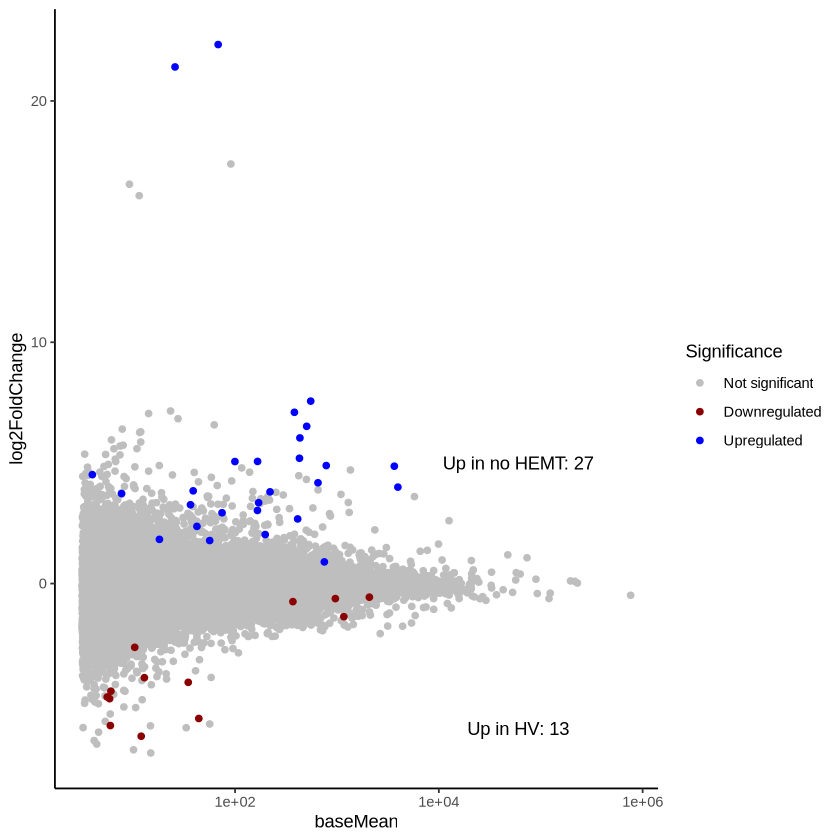

In [35]:
ggplot(nohemt.vs.hv, aes(x=baseMean, y=log2FoldChange)) +
    geom_point(aes(fill=sign, color=sign), stroke=0.5) +
    # ylim(-10, 10)
    #geom_label_repel(
    #    aes(label = GENENAME, fontface = "italic"), 
    #    data = nohemt.vs.hv[nohemt.vs.hv$padj < 0.05, ],
    #    box.padding = 0.5,
    #    seed = 5000,
    #) +
    scale_x_log10() +
    scale_color_manual(values = c("gray", "darkred", "blue"), name = "Significance", labels = c("Not significant", "Downregulated", "Upregulated")) +
    scale_fill_manual(values = c("gray", "darkred", "blue"), name = "Significance", labels = c("Not significant", "Downregulated", "Upregulated")) + 
    annotate("text", x = 6e+04, y = 5, label = sprintf("Up in no HEMT: %d", sum(nohemt.vs.hv$sign == "Up"))) +
    annotate("text", x = 6e+04, y = -6, label = sprintf("Up in HV: %d", sum(nohemt.vs.hv$sign == "Down"))) +
    theme_classic()

ggsave(file.path(fig2.out.dir, "fig2b.png"), height=3, width=5, dpi=300, unit='in')
ggsave(file.path(fig2.out.dir, "fig2b.svg"), height=3, width=5, dpi=300, unit='in')

In [36]:
hemt.vs.hv <- as.data.frame(results(fig2.hemt.dds, contrast=c("hemt", "Y", "HV")))
hemt.vs.hv <- hemt.vs.hv[!is.na(hemt.vs.hv$padj), ]
hemt.vs.hv$sign <- ""
hemt.vs.hv$sign[(hemt.vs.hv$log2FoldChange < 0) & (hemt.vs.hv$padj < 0.05)] <- "Down"
hemt.vs.hv$sign[(hemt.vs.hv$log2FoldChange > 0) & (hemt.vs.hv$padj < 0.05)] <- "Up"
hemt.vs.hv <- hemt.vs.hv[order(hemt.vs.hv$sign), ]
hemt.vs.hv$GENENAME <- tx2gene[match(rownames(hemt.vs.hv), tx2gene$GENEID), ]$GENENAME

In [37]:
hemt.vs.hv[hemt.vs.hv$padj < 0.05, ]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,sign,GENENAME
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSG00000008130,9.616838e+02,-1.0200520,0.2481691,-4.110310,3.951285e-05,2.656009e-02,Down,NADK
ENSG00000011422,1.181142e+03,-2.6670508,0.6995875,-3.812319,1.376690e-04,4.379105e-02,Down,PLAUR
ENSG00000049249,2.168952e+01,-3.1415018,0.8211635,-3.825671,1.304161e-04,4.379105e-02,Down,TNFRSF9
ENSG00000050555,1.289716e+01,-3.0454022,0.7341775,-4.148046,3.353249e-05,2.297363e-02,Down,LAMC3
ENSG00000051523,1.228556e+03,-0.6572272,0.1756639,-3.741390,1.830052e-04,4.939199e-02,Down,CYBA
ENSG00000074706,8.003676e+01,-1.2877510,0.3437508,-3.746176,1.795504e-04,4.882948e-02,Down,IPCEF1
ENSG00000077522,2.834055e+01,-3.4363411,0.8666475,-3.965097,7.336621e-05,3.391362e-02,Down,ACTN2
ENSG00000095713,8.697585e+00,-2.5343126,0.6556855,-3.865134,1.110281e-04,4.285755e-02,Down,CRTAC1
ENSG00000099308,3.053104e+02,-1.4559470,0.3768687,-3.863274,1.118776e-04,4.285755e-02,Down,MAST3


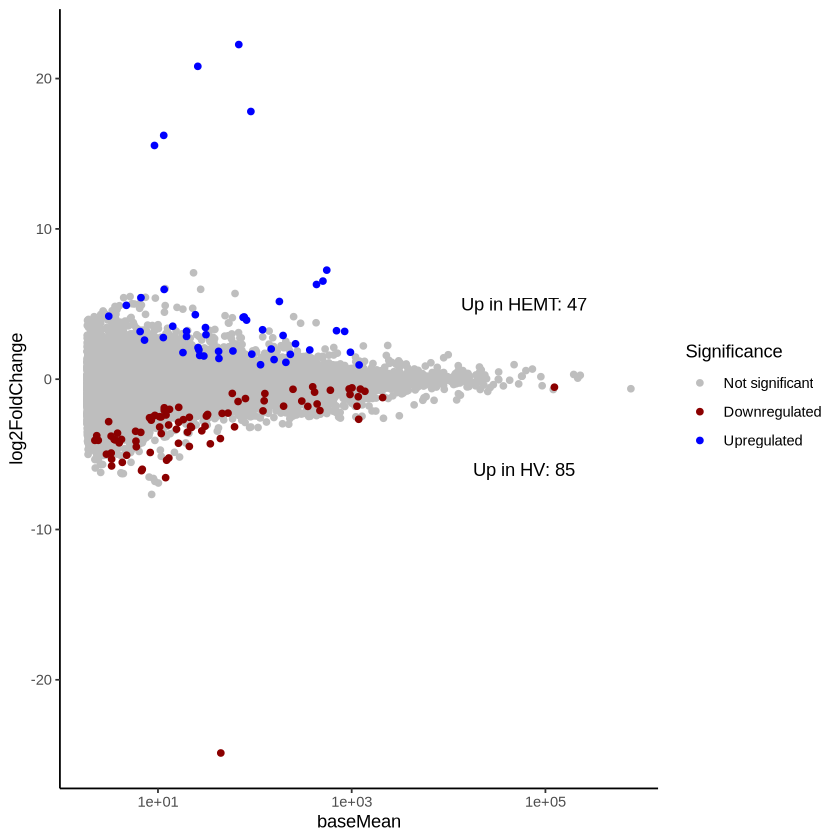

In [38]:
ggplot(hemt.vs.hv, aes(x=baseMean, y=log2FoldChange)) +
    geom_point(aes(fill=sign, color=sign), stroke=0.5) +
    # ylim(-10, 10)
    #geom_label_repel(
    #    aes(label = GENENAME, fontface = "italic"), 
    #    data = hemt.vs.hv[hemt.vs.hv$padj < 0.05, ],
    #    box.padding = 0.5,
    #    seed = 5000,
    #) +
    scale_x_log10() +
    scale_color_manual(values = c("gray", "darkred", "blue"), name = "Significance", labels = c("Not significant", "Downregulated", "Upregulated")) +
    scale_fill_manual(values = c("gray", "darkred", "blue"), name = "Significance", labels = c("Not significant", "Downregulated", "Upregulated")) + 
    annotate("text", x = 6e+04, y = 5, label = sprintf("Up in HEMT: %d", sum(hemt.vs.hv$sign == "Up"))) +
    annotate("text", x = 6e+04, y = -6, label = sprintf("Up in HV: %d", sum(hemt.vs.hv$sign == "Down"))) +
    theme_classic()

ggsave(file.path(fig2.out.dir, "fig2c.png"), height=3, width=5, dpi=300, unit='in')
ggsave(file.path(fig2.out.dir, "fig2c.svg"), height=3, width=5, dpi=300, unit='in')

## DEG Overlap

In [39]:
gene.lists <- list("HEMT vs. HV" = rownames(hemt.vs.hv[hemt.vs.hv$padj < 0.05, ]),
                   "No HEMT vs. HV" = rownames(nohemt.vs.hv[nohemt.vs.hv$padj < 0.05, ]),
                   "HEMT vs. No HEMT" = rownames(hemt.vs.nohemt[hemt.vs.nohemt$padj < 0.05, ])
                  )

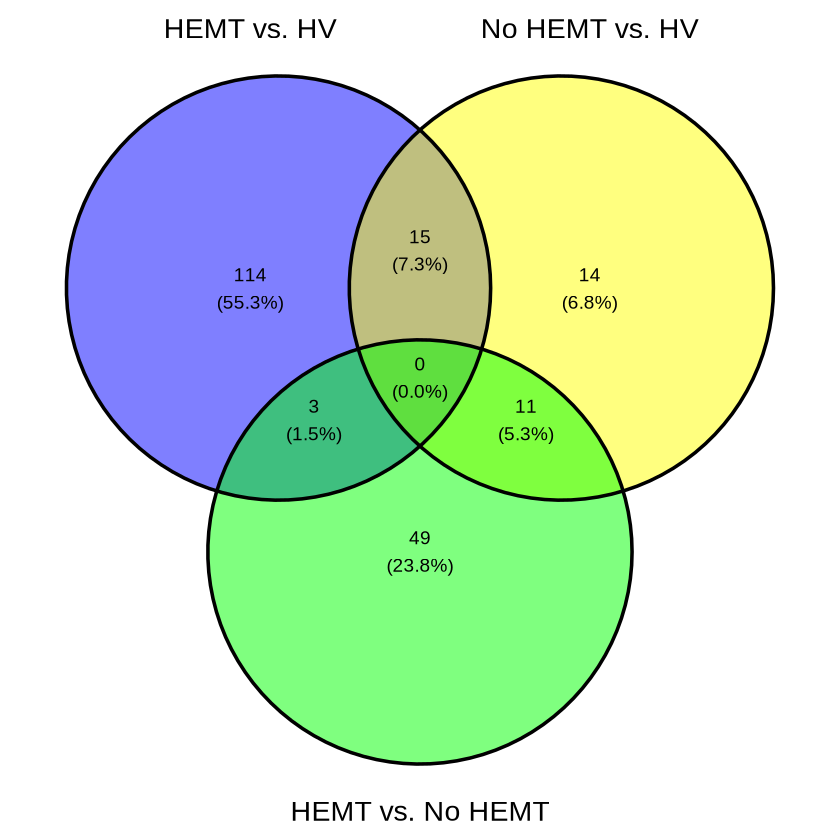

In [40]:
ggvenn(gene.lists)
ggsave(file.path(fig2.out.dir, "fig2d.png"), height=4.5, width=4.5, dpi=300, unit='in')
ggsave(file.path(fig2.out.dir, "fig2d.svg"), height=4.5, width=4.5, dpi=300, unit='in')

## ORA Analysis

In [46]:
fig1.degs <- cf.vs.ctrl[cf.vs.ctrl$padj < 0.05, ]

fig1.deg.gl <- fig1.degs$log2FoldChange
names(fig1.deg.gl) <- rownames(fig1.degs)
fig1.gl <- na.omit(fig1.deg.gl)
fig1.gl <- sort(fig1.gl, decreasing=TRUE)

fig1.gl.up <- fig1.gl[fig1.gl>0]
fig1.gl.down <- fig1.gl[fig1.gl<0]

In [47]:
ego.up <- enrichGO(gene=names(fig1.gl.up),
                   OrgDb=org.Hs.eg.db,
                   universe=rownames(cf.vs.ctrl),
                   key='ENSEMBL',
                   readable=TRUE
                  )
ego.up

#
# over-representation test
#
#...@organism 	 Homo sapiens 
#...@ontology 	 MF 
#...@keytype 	 ENSEMBL 
#...@gene 	 chr [1:46] "ENSG00000206932" "ENSG00000274917" "ENSG00000267520" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...11 enriched terms found
'data.frame':	11 obs. of  9 variables:
 $ ID         : chr  "GO:0005344" "GO:0019825" "GO:0004601" "GO:0016684" ...
 $ Description: chr  "oxygen carrier activity" "oxygen binding" "peroxidase activity" "oxidoreductase activity, acting on peroxide as acceptor" ...
 $ GeneRatio  : chr  "3/14" "3/14" "3/14" "3/14" ...
 $ BgRatio    : chr  "10/16288" "30/16288" "46/16288" "48/16288" ...
 $ pvalue     : num  6.04e-08 2.02e-06 7.51e-06 8.55e-06 3.29e-05 ...
 $ p.adjust   : num  2.06e-06 3.44e-05 7.26e-05 7.26e-05 2.18e-04 ...
 $ qvalue     : num  1.02e-06 1.70e-05 3.60e-05 3.60e-05 1.08e-04 ...
 $ geneID     : chr  "HBA1/HBB/HBA2" "HBA1/HBB/HBA2" "HBA1/HBB/HBA2" "HBA1/HBB/HBA2" ...
 $ Count      : int  3 3 3 3 3 3 3 3 3 2 ...
#...Cita

In [48]:
ego.down <- enrichGO(gene=names(fig1.gl.down),
                   OrgDb=org.Hs.eg.db,
                   universe=rownames(cf.vs.ctrl),
                   key='ENSEMBL',
                   readable=TRUE
                  )
ego.down

#
# over-representation test
#
#...@organism 	 Homo sapiens 
#...@ontology 	 MF 
#...@keytype 	 ENSEMBL 
#...@gene 	 chr [1:50] "ENSG00000128272" "ENSG00000177606" "ENSG00000170892" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...0 enriched terms found
#...Citation
 T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu.
 clusterProfiler 4.0: A universal enrichment tool for interpreting omics data.
 The Innovation. 2021, 2(3):100141 


In [49]:
fig2.hemt.nohemt.degs <- hemt.vs.nohemt[hemt.vs.nohemt$padj < 0.05, ]

fig2.hemt.nohemt.deg.gl <- fig2.hemt.nohemt.degs$log2FoldChange
names(fig2.hemt.nohemt.deg.gl) <- rownames(fig2.hemt.nohemt.degs)
fig2.hemt.nohemt.gl <- na.omit(fig2.hemt.nohemt.deg.gl)
fig2.hemt.nohemt.gl <- sort(fig2.hemt.nohemt.gl, decreasing=TRUE)

fig2.hemt.nohemt.gl.up <- fig2.hemt.nohemt.gl[fig2.hemt.nohemt.gl>0]
fig2.hemt.nohemt.gl.down <- fig2.hemt.nohemt.gl[fig2.hemt.nohemt.gl<0]

In [50]:
ego.up <- enrichGO(gene=names(fig2.hemt.nohemt.gl.up),
                   OrgDb=org.Hs.eg.db,
                   universe=rownames(hemt.vs.nohemt),
                   key='ENSEMBL',
                   readable=TRUE
                  )
ego.up

#
# over-representation test
#
#...@organism 	 Homo sapiens 
#...@ontology 	 MF 
#...@keytype 	 ENSEMBL 
#...@gene 	 chr [1:7] "ENSG00000165168" "ENSG00000249846" "ENSG00000122877" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...20 enriched terms found
'data.frame':	20 obs. of  9 variables:
 $ ID         : chr  "GO:0020037" "GO:0046906" "GO:0005244" "GO:0022832" ...
 $ Description: chr  "heme binding" "tetrapyrrole binding" "voltage-gated ion channel activity" "voltage-gated channel activity" ...
 $ GeneRatio  : chr  "2/6" "2/6" "2/6" "2/6" ...
 $ BgRatio    : chr  "114/15125" "123/15125" "168/15125" "168/15125" ...
 $ pvalue     : num  0.000828 0.000963 0.001787 0.001787 0.004356 ...
 $ p.adjust   : num  0.0264 0.0264 0.0264 0.0264 0.0331 ...
 $ qvalue     : num  0.0122 0.0122 0.0122 0.0122 0.0153 ...
 $ geneID     : chr  "CYBB/CYP1B1" "CYBB/CYP1B1" "CYBB/KCNK5" "CYBB/KCNK5" ...
 $ Count      : int  2 2 2 2 1 2 1 1 1 1 ...
#...Citation
 T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, 

In [51]:
ego.down <- enrichGO(gene=names(fig2.hemt.nohemt.gl.down),
                   OrgDb=org.Hs.eg.db,
                   universe=rownames(hemt.vs.nohemt),
                   key='ENSEMBL',
                   readable=TRUE
                  )
ego.down

#
# over-representation test
#
#...@organism 	 Homo sapiens 
#...@ontology 	 MF 
#...@keytype 	 ENSEMBL 
#...@gene 	 chr [1:56] "ENSG00000105559" "ENSG00000161956" "ENSG00000129521" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...0 enriched terms found
#...Citation
 T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu.
 clusterProfiler 4.0: A universal enrichment tool for interpreting omics data.
 The Innovation. 2021, 2(3):100141 


In [52]:
fig2.hemt.hv.degs <- hemt.vs.hv[hemt.vs.hv$padj < 0.05, ]

fig2.hemt.hv.deg.gl <- fig2.hemt.hv.degs$log2FoldChange
names(fig2.hemt.hv.deg.gl) <- rownames(fig2.hemt.hv.degs)
fig2.hemt.hv.gl <- na.omit(fig2.hemt.hv.deg.gl)
fig2.hemt.hv.gl <- sort(fig2.hemt.hv.gl, decreasing=TRUE)

fig2.hemt.hv.gl.up <- fig2.hemt.hv.gl[fig2.hemt.hv.gl>0]
fig2.hemt.hv.gl.down <- fig2.hemt.hv.gl[fig2.hemt.hv.gl<0]

In [53]:
ego.up <- enrichGO(gene=names(fig2.hemt.hv.gl.up),
                   OrgDb=org.Hs.eg.db,
                   universe=rownames(hemt.vs.hv),
                   key='ENSEMBL',
                   readable=TRUE
                  )
ego.up

#
# over-representation test
#
#...@organism 	 Homo sapiens 
#...@ontology 	 MF 
#...@keytype 	 ENSEMBL 
#...@gene 	 chr [1:47] "ENSG00000206932" "ENSG00000269711" "ENSG00000274917" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...10 enriched terms found
'data.frame':	10 obs. of  9 variables:
 $ ID         : chr  "GO:0005344" "GO:0020037" "GO:0046906" "GO:0140104" ...
 $ Description: chr  "oxygen carrier activity" "heme binding" "tetrapyrrole binding" "molecular carrier activity" ...
 $ GeneRatio  : chr  "3/21" "5/21" "5/21" "4/21" ...
 $ BgRatio    : chr  "10/16300" "127/16300" "136/16300" "79/16300" ...
 $ pvalue     : num  2.20e-07 4.88e-07 6.86e-07 2.87e-06 8.09e-06 ...
 $ p.adjust   : num  1.28e-05 1.33e-05 1.33e-05 4.17e-05 9.39e-05 ...
 $ qvalue     : num  8.33e-06 8.67e-06 8.67e-06 2.72e-05 6.13e-05 ...
 $ geneID     : chr  "HBA1/HBB/HBA2" "HBA1/HBB/HBA2/CYBB/CYP7B1" "HBA1/HBB/HBA2/CYBB/CYP7B1" "HBA1/HBB/HBA2/TF" ...
 $ Count      : int  3 5 5 4 3 3 4 3 3 3
#...Citation


In [54]:
ego.down <- enrichGO(gene=names(fig2.hemt.hv.gl.down),
                   OrgDb=org.Hs.eg.db,
                   universe=rownames(hemt.vs.hv),
                   key='ENSEMBL',
                   readable=TRUE
                  )
ego.down

#
# over-representation test
#
#...@organism 	 Homo sapiens 
#...@ontology 	 MF 
#...@keytype 	 ENSEMBL 
#...@gene 	 chr [1:85] "ENSG00000156931" "ENSG00000202198" "ENSG00000137312" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...0 enriched terms found
#...Citation
 T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu.
 clusterProfiler 4.0: A universal enrichment tool for interpreting omics data.
 The Innovation. 2021, 2(3):100141 


## Quick Gene Check

Prior lit has EGR1 up, but our single cell has EGR1 down in secretory cells. Let's visualize it in our bulk data.

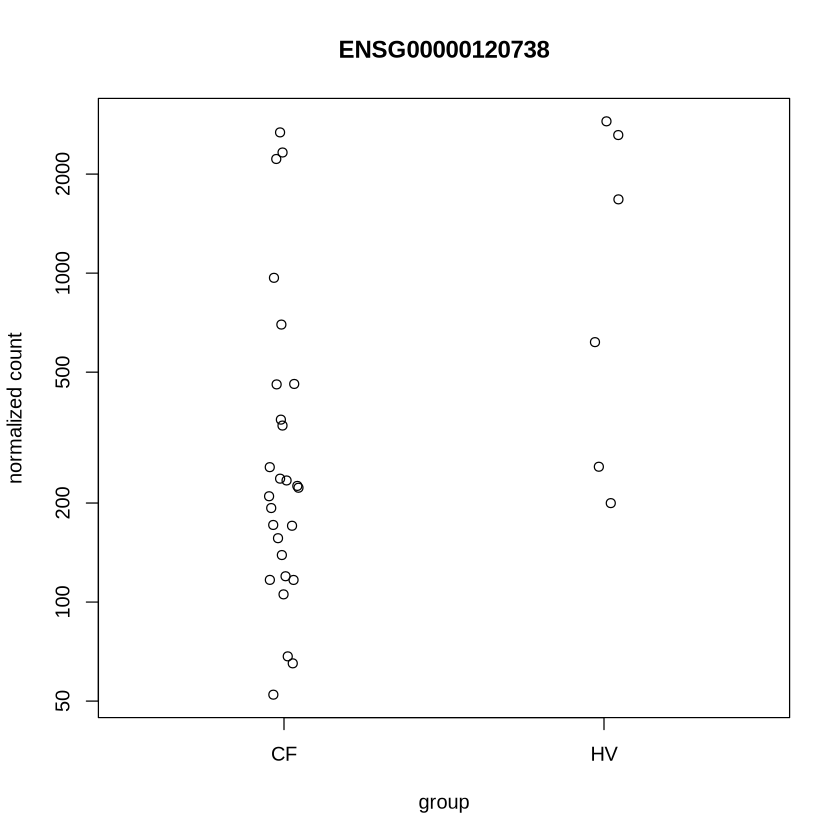

In [41]:
plotCounts(fig1.dds, gene="ENSG00000120738", intgroup="condition")

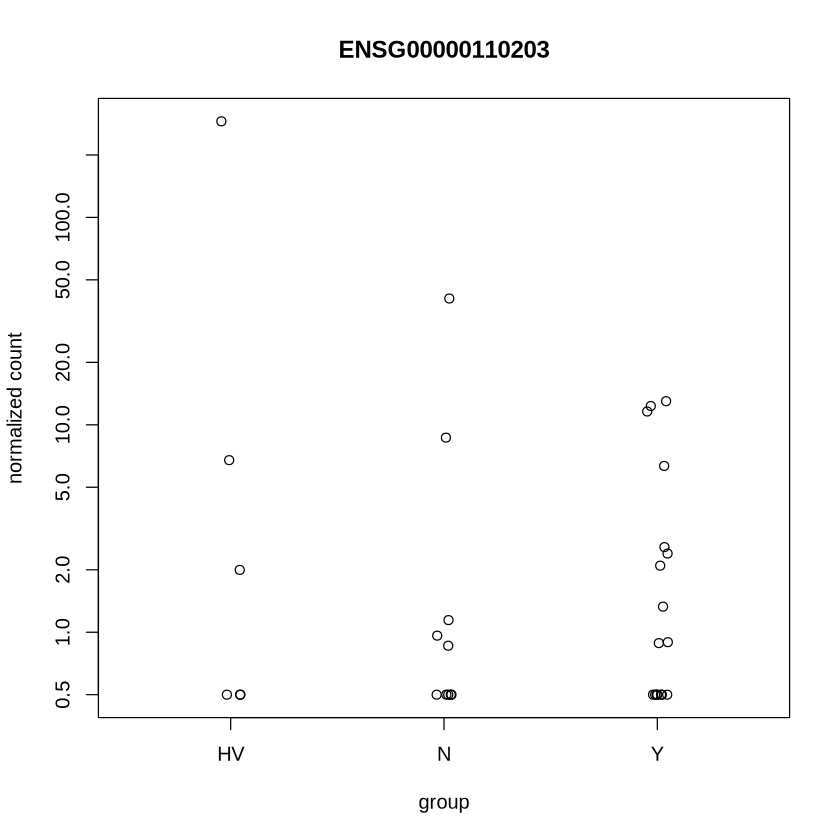

In [45]:
plotCounts(fig2.hemt.dds, gene="ENSG00000110203", intgroup="hemt")